Use unlabelled train set with prediction label to train.
</br>
We previously randomly choose 3000 instances from the unlabelled set and predict them so that they have labels. Now we will use these samples with our original labelled train set to train our model.

In [1]:
! gdown https://drive.google.com/uc?id=1AbxjCBByF-xGV3c7FJ1ztZC1HO0O0uJ0

Downloading...
From: https://drive.google.com/uc?id=1AbxjCBByF-xGV3c7FJ1ztZC1HO0O0uJ0
To: /content/kaggle.json
100% 66.0/66.0 [00:00<00:00, 133kB/s]


In [2]:
! pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
! kaggle competitions download -c comp-551-fall-2021
! unzip images_l.pkl.zip
! unzip images_test.pkl.zip
! unzip images_ul.pkl.zip
! unzip labels_l.pkl.zip

 85% 84.0M/99.0M [00:00<00:00, 145MB/s]
100% 99.0M/99.0M [00:00<00:00, 166MB/s]
 90% 178M/198M [00:00<00:00, 194MB/s]
100% 198M/198M [00:01<00:00, 202MB/s]
 98% 193M/197M [00:00<00:00, 218MB/s]
100% 197M/197M [00:00<00:00, 217MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 145MB/s]
Archive:  images_l.pkl.zip
  inflating: images_l.pkl            
Archive:  images_test.pkl.zip
  inflating: images_test.pkl         
Archive:  images_ul.pkl.zip
  inflating: images_ul.pkl           
Archive:  labels_l.pkl.zip
  inflating: labels_l.pkl            


In [3]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU, ZeroPadding2D,Convolution2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Nadam, Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet152, ResNet101, ResNet50
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import layers, regularizers, Input
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from google.colab import drive
import h5py
import random

In [4]:
# Image data for training (30,000 sample, each sample is a 56x56 image)
# train_labels = pd.read_csv('train_max_y.csv')
# train_images = pd.read_pickle('train_max_x')
# test_images = pd.read_pickle('test_max_x')
with open("images_l.pkl", 'rb') as f:
    # load into as a numpy array
    train_labelled_data = pickle.load(f)
# Test images. The prediction corresponding to these images should be uploaded. (15,000 samples)
with open("images_test.pkl", 'rb') as f:
    test_data = pickle.load(f)
# Labels for training (30,000 rows, each row is a size 36 binary vector, which is the label to the corresponding image)
with open("labels_l.pkl", 'rb') as f:
    train_labelled_y = pickle.load(f)
# Additional images that can be used for training the classifier.
# Labels for these images are not provided. (30,000 samples, where each sample is a 56x56 image)
with open("images_ul.pkl", 'rb') as f:
    train_unlabelled_x = pickle.load(f)

# processing

In [5]:
# load already process train, test data
! gdown https://drive.google.com/uc?id=1wyUpGYONbWRjdaLgeiEH2ryqm_kMOMF_
! gdown https://drive.google.com/uc?id=1tFt0ddczfNPmq8IUNnZ8ifGUbgzP9DxU
! gdown https://drive.google.com/uc?id=1bOq70mP5ghxfiFtbK3rTbPDcefkxgyQx
! gdown https://drive.google.com/uc?id=1oSJM0BtYu_hiJ7mkSNphJLAmBVnznO4o

Downloading...
From: https://drive.google.com/uc?id=1wyUpGYONbWRjdaLgeiEH2ryqm_kMOMF_
To: /content/processed_train_set.csv
100% 386M/386M [00:01<00:00, 214MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tFt0ddczfNPmq8IUNnZ8ifGUbgzP9DxU
To: /content/processed_test_set.csv
100% 193M/193M [00:00<00:00, 204MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bOq70mP5ghxfiFtbK3rTbPDcefkxgyQx
To: /content/processed_ul_train_set.csv
100% 386M/386M [00:01<00:00, 227MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oSJM0BtYu_hiJ7mkSNphJLAmBVnznO4o
To: /content/ul_train_label.csv
100% 216k/216k [00:00<00:00, 63.9MB/s]


# Digit

In [6]:
def cnn():
    # create model
    model = Sequential()
    vgg16 =  VGG16(weights='imagenet', include_top=False, input_shape=(56,56,3))
    #res = ResNet152(weights='imagenet', include_top=False, input_shape=(56,56,3))
# des = DenseNet169(weights='imagenet', include_top=False, input_shape=(56,56,3))
    model.add(vgg16)
# model.add(des)
# model.add(res)
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    # Compile
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = cnn()
model.summary() 

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1000)              513000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10010     
                                                                 
Total params: 15,237,698
Trainable params: 15,237,698
Non-trainable params: 0
_____________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Digit prediction is noise senstitive, so need to use clear_noise data.

In [7]:
train_labelled_x=np.array(pd.DataFrame(pd.read_csv('processed_train_set.csv')))
train_labelled_x=train_labelled_x.reshape((30000,56,56))
train_unlabelled_x = np.array(pd.DataFrame(pd.read_csv('processed_ul_train_set.csv')))
train_unlabelled_x = train_unlabelled_x.reshape((30000,56,56))
train_unlabelled_x = train_unlabelled_x[0:3000]
train_unlabelled_y = np.array(pd.DataFrame(pd.read_csv('ul_train_label.csv')))

train_labelled_x = np.concatenate((train_unlabelled_x,train_labelled_x),axis=0)
train_labelled_y = np.concatenate((train_unlabelled_y,train_labelled_y),axis=0)

In [8]:
x_train = train_labelled_x
y_train = train_labelled_y
for i in range(x_train.shape[0]):
  x_train[i] = (x_train[i]>200).astype('int32')*255
import torch

x_train = torch.Tensor(x_train)
x_train = torch.unsqueeze(x_train, dim=3)/255.
x_train = x_train.repeat(1,1,1,3)
x_train = x_train.numpy()
x_train = x_train.astype('float32')
x_valid = x_train[29500:30000, :]
x_train = x_train[:29500, :]
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)

# y_train = keras.utils.to_categorical(y_train, 10)
a = y_train
y_valid = y_train[29500:30000, :10]
y_train = y_train[:29500, :10]
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)

x_train shape: (29500, 56, 56, 3)
x_valid shape: (500, 56, 56, 3)
y_train shape: (29500, 10)
y_valid shape: (500, 10)


In [9]:
for i in range(25):
  print('Trail: ',i)
  history = model.fit(x_train, y_train, batch_size=100, epochs=1, verbose=1)
  score = model.evaluate(x_valid, y_valid, verbose=1)
  model.save('VGG16_2_SP_{}'.format(i))

Trail:  0
16/16 [==============================] - 1s 23ms/step - loss: 0.4255 - accuracy: 0.8800
INFO:tensorflow:Assets written to: VGG16_2_SP_0/assets
Trail:  1
16/16 [==============================] - 0s 11ms/step - loss: 0.3319 - accuracy: 0.9280
INFO:tensorflow:Assets written to: VGG16_2_SP_1/assets
Trail:  2
16/16 [==============================] - 0s 10ms/step - loss: 0.2810 - accuracy: 0.9440
INFO:tensorflow:Assets written to: VGG16_2_SP_2/assets
Trail:  3
16/16 [==============================] - 0s 11ms/step - loss: 0.3154 - accuracy: 0.9280
INFO:tensorflow:Assets written to: VGG16_2_SP_3/assets
Trail:  4
16/16 [==============================] - 0s 11ms/step - loss: 0.3027 - accuracy: 0.9100
INFO:tensorflow:Assets written to: VGG16_2_SP_4/assets
Trail:  5
16/16 [==============================] - 0s 11ms/step - loss: 0.2793 - accuracy: 0.9320
INFO:tensorflow:Assets written to: VGG16_2_SP_5/assets
Trail:  6
16/16 [==============================] - 0s 11ms/step - loss: 0.3161 - a

load processed test data

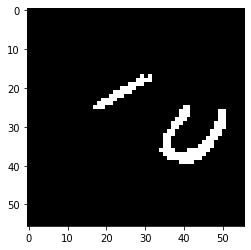

In [10]:
# load testing data for model testing
x_test=np.array(pd.DataFrame(pd.read_csv('processed_test_set.csv')))

x_test=x_test.reshape((15000,56,56))

import matplotlib.pyplot as plt
import random

plt.imshow(x_test[random.randint(0,14999)], cmap="gray")
plt.show()

# with open("images_test.pkl",'rb') as f:
#   x_test = pickle.load(f)
for i in range(x_test.shape[0]):
  x_test[i] = (x_test[i]>200).astype('int32')*255
x_test = torch.Tensor(x_test)
x_test = torch.unsqueeze(x_test,dim=3)/255
x_test = x_test.repeat(1,1,1,3)
x_test = x_test.numpy()
x_test = x_test.astype('float32')

In [11]:
result = model.predict(x_test,verbose=1)
result = np.argmax(result, axis = 1)
print(result[0:10])

469/469 [==============================] - 4s 9ms/step
[0 4 9 0 6 9 3 2 1 6]


# Letter 

In [12]:
def cnn2():
  model = Sequential()
  model.add(Input(shape=(56, 56, 1)))
  model.add(Conv2D(filters= 56, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(Conv2D(filters= 56, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.6))

  model.add(Conv2D(filters= 128, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(Conv2D(filters= 128, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.6))

  model.add(Conv2D(filters= 256, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(Conv2D(filters= 256, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.6))

  model.add(Conv2D(filters= 512, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(Conv2D(filters= 512, kernel_size=(3,3), padding='Same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.6))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(26, activation='softmax'))
  model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
  return model
model2=cnn2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 56)        560       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 56)        28280     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 56)       224       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 56)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 56)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)      

In [13]:
# # reload train data for model2 training
# train_labelled_x=np.array(pd.DataFrame(pd.read_csv('processed_train_set.csv')))

# train_labelled_x=train_labelled_x.reshape((30000,56,56))

with open("images_l.pkl", 'rb') as f:
    # load into as a numpy array
    train_labelled_data = pickle.load(f)

# Labels for training (30,000 rows, each row is a size 36 binary vector, which is the label to the corresponding image)
with open("labels_l.pkl", 'rb') as f:
    train_labelled_y = pickle.load(f)

with open("images_ul.pkl", 'rb') as f:
    train_unlabelled_x = pickle.load(f)

train_labelled_x = train_labelled_data

train_unlabelled_x = train_unlabelled_x[0:3000]
train_unlabelled_y = np.array(pd.DataFrame(pd.read_csv('ul_train_label.csv')))

train_labelled_x = np.concatenate((train_unlabelled_x,train_labelled_x),axis=0)
train_labelled_y = np.concatenate((train_unlabelled_y,train_labelled_y),axis=0)

In [14]:
letter_train = train_labelled_x.reshape(-1, 56, 56, 1)
# letter_train /= 255
letter_train_label = train_labelled_y[:, 10:]
x_train2 = letter_train[:29000,:,:,:]
y_train2 = letter_train_label[:29000,:]
x_valid2 = letter_train[29000:,:,:,:]
y_valid2 = letter_train_label[29000:,:]

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_dense_1_accuracy', patience=2, verbose=1,factor=0.8, min_lr=0.000001)
history = model2.fit(x_train2, y_train2, epochs=40, batch_size=128,
          validation_data=(x_valid2, y_valid2), 
          callbacks=[reduce_lr], shuffle=False)

Epoch 1/40
227/227 [==============================] - 17s 64ms/step - loss: 4.1275 - accuracy: 0.0685 - val_loss: 15.9727 - val_accuracy: 0.0355 - lr: 0.0010
Epoch 2/40
227/227 [==============================] - 13s 59ms/step - loss: 3.4882 - accuracy: 0.0931 - val_loss: 3.1136 - val_accuracy: 0.1080 - lr: 0.0010
Epoch 3/40
227/227 [==============================] - 14s 60ms/step - loss: 3.1380 - accuracy: 0.1264 - val_loss: 3.0328 - val_accuracy: 0.1353 - lr: 0.0010
Epoch 4/40
227/227 [==============================] - 14s 60ms/step - loss: 2.8874 - accuracy: 0.1674 - val_loss: 3.6716 - val_accuracy: 0.1095 - lr: 0.0010
Epoch 5/40
227/227 [==============================] - 14s 60ms/step - loss: 2.5586 - accuracy: 0.2473 - val_loss: 4.5459 - val_accuracy: 0.1093 - lr: 0.0010
Epoch 6/40
227/227 [==============================] - 14s 60ms/step - loss: 2.2359 - accuracy: 0.3452 - val_loss: 3.0980 - val_accuracy: 0.2278 - lr: 0.0010
Epoch 7/40
227/227 [==============================] - 14s

In [16]:
# # load testing data for model testing
# x_test_data=np.array(pd.DataFrame(pd.read_csv('processed_test_set.csv')))

# x_test_data=x_test_data.reshape((15000,56,56))

# import matplotlib.pyplot as plt
# import random

# plt.imshow(x_test_data[random.randint(0,14999)], cmap="gray")
# plt.show()

with open("images_test.pkl",'rb') as f:
  x_test_data = pickle.load(f)
x_test = x_test_data.reshape(-1,56,56,1)
# x_test /= 255

In [ ]:
pickle.dump(model, open('model1.pkl', 'wb'))
pickle.dump(model2, open('model2.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://e72e63aa-5425-4a0c-b01b-cedd7809f74e/assets
INFO:tensorflow:Assets written to: ram://fcf3d2a5-7256-4792-bf75-3c2b64402221/assets


In [17]:
result2 = model2.predict(x_test, verbose=1)
result2 = np.argmax(result2, axis = 1)
print(result2[0:10])

469/469 [==============================] - 3s 5ms/step
[19 11  9 11  9 24 14 18 22  6]


# output

In [ ]:
# transform 0-9 number to string like 0100000000, 0000001000
def transform_digit (num):
    temp_list = np.zeros(10)
    temp_list[num]=1
    temp_list = temp_list.astype(int)
    str1 = ''.join(str(i) for i in temp_list)
    return str1

# tranform 0-25 number to 26-bit string with the index at the num value to be 1
def transform_letter (num):
    temp_list = np.zeros(26)
    temp_list[num] = 1
    
    temp_list = temp_list.astype(int)
    str1 = ''.join(str(i) for i in temp_list)
    return str1

output = list()
for i in range (0,result.shape[0]):
    tempStr = transform_digit(result[i])+transform_letter(result2[i])
    output.append([i,tempStr])

In [ ]:
df=pd.DataFrame(output)
df.columns = ['# Id','Category']
df.to_csv('result.csv',index=False)